# Supporting functions
Load at the beggining 

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from PIL import Image

In [2]:
def iou_range(x):
  if x == 0:
    return 'IoU = 0'
  elif x < 0.5 :
    return 'IoU < 0.5'
  else:
    return 'IoU > 0.5'

def calculate_area(x):
  try:
    width=x[2]-x[0]
    height=x[3]-x[1]
    return width*height
  except:
    return 0

def return_label_name(x, dic):
  try:
    return dic[x]
  except:
    return -1

def calculate_aspect(x):
  try:
    width=x[2]-x[0]
    height=x[3]-x[1]
    return height/width
  except:
    return 0

In [3]:
def transform_frcnn(dic, prediction_path, annot_test_path):
  
  #supporting functions
  def calculate_iou(x):
    bb1 = x.true_bounding
    bb2 = x.pred_bounding
    try:
      x_left = max(bb1[0], bb2[0])
      y_top = max(bb1[1], bb2[1])
      x_right = min(bb1[2], bb2[2])
      y_bottom = min(bb1[3], bb2[3])

      if x_right < x_left or y_bottom < y_top:
        return 0.0

      intersection_area = (x_right - x_left) * (y_bottom - y_top)

      bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
      bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

      iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

      return iou
    except:
      return 0


  def transform_bbx(x):
    try:
      x[0]
      return x
    except:
      return [[0,0,0,0]]

  def transform(x):
    try:
      x[0]
      return x
    except:
      return [0]

  def calculate_area(x):
    try:
      width=x[2]-x[0]
      height=x[3]-x[1]
      return width*height
    except:
      return 0

  
  print('Transforming data ... ')
  test_pred=pd.read_csv(prediction_path)

  #load csv containing info about true labels and images
  with open(annot_test_path) as json_file:
    data = json.load(json_file)
    test_label=pd.DataFrame(data['annotations']).rename(columns={'category_id':'true_label'})
    get_pic_name=pd.DataFrame(data['images']).loc[:,['id','file_name']].rename(columns={'id':'image_id','file_name':'picture'})


  #change tuple into list
  test_pred['boxes']=test_pred['boxes'].apply(ast.literal_eval)
  test_pred['boxes_hat']=test_pred['boxes_hat'].apply(ast.literal_eval)
  test_pred['labels_hat']=test_pred['labels_hat'].apply(ast.literal_eval)
  test_pred['scores']=test_pred['scores'].apply(ast.literal_eval)

  #make bboxes 
  test_pred['boxes_hat']=test_pred.boxes_hat.apply(transform_bbx)
  test_pred['labels_hat']=test_pred.labels_hat.apply(transform)
  test_pred['scores']=test_pred.scores.apply(transform)

  #make a row for each prediction
  test_pred = pd.DataFrame({'true_bounding': np.repeat(test_pred.boxes.values, test_pred.boxes_hat.str.len()),
              'pred_label': np.repeat(test_pred.labels.values, test_pred.boxes_hat.str.len()),
              'image_id': np.repeat(test_pred.image_id.values, test_pred.boxes_hat.str.len()),

              'pred_label': np.concatenate(test_pred.labels_hat.values),
              'list_conf': np.concatenate(test_pred.scores.values),
              'pred_bounding': [list(x) for x in np.concatenate(test_pred.boxes_hat.values)]})

  test_pred=test_pred.merge(test_label.loc[:,["true_label","image_id"]], on ='image_id', how='left')
  test_pred=test_pred.merge(get_pic_name, on ='image_id', how='left')

  test_pred['list_iou']=test_pred.apply(calculate_iou,axis=1)
  test_pred['iou_range']=test_pred['list_iou'].apply(iou_range)
  test_pred['confidence_range']=test_pred['list_conf'].apply(iou_range)
  test_pred['area_predicted']=test_pred['pred_bounding'].apply(calculate_area)
  test_pred['area_true']=test_pred['true_bounding'].apply(calculate_area)
  test_pred['true_label_name']=test_pred['true_label'].apply(lambda x: return_label_name(x,dic))
  test_pred=test_pred[test_pred['true_label_name']!=-1]
  test_pred['aspect_ratio_true']=test_pred['true_bounding'].apply(calculate_aspect)

  print("Data successfully transformed!")

  return test_pred



In [4]:
import cv2

import matplotlib.patches as patches

def show_box(box, ax,**kwargs):    
 
      x, y = box[0],box[1]
      width,height = box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y),
                                      width, height,
                                      **kwargs)

      ax.add_patch(rect)

In [5]:
def show_bbox(test_pic_path, pictures_investigate, test_pred, n_show=3, start=-1):

  assert n_show % 3 == 0

  rows= int(n_show / 3)
  fig, axes = plt.subplots(rows,3,figsize = (30,15), squeeze=True)
  axes = axes.reshape(-1)
  pic_show = pictures_investigate.loc[:,'picture'].unique()

  if start == -1:
    start=np.random.randint(0,len(pic_show)-n_show)
  else:
    start = start


  for i, ax in  enumerate(axes):
    pic=pic_show[start+i]
    image = Image.open(test_pic_path + pic)
    resized_image = image.resize((img_size,img_size))

    true_bb=test_pred.loc[test_pred['picture']==pic, 'true_bounding'].values[0]

    show_box(true_bb, ax , linewidth = 2,edgecolor = 'blue',facecolor = 'none')
    
    for box, iou, conf in np.array(test_pred.loc[test_pred['picture']==pic, ['pred_bounding','list_iou','list_conf']]):
      if conf > confidence:
        show_box(box, ax , linewidth = 2,edgecolor = 'red',facecolor = 'none')
    ax.imshow(resized_image)

In [6]:
def transform_yolo(dic, prediction_path, annot_test_path):

  def order(x):
    return [x[0],x[2],x[1],x[3]]

  print('Transforming data ... ')

  def add_extention(x):
    return x + '.jpg'
  
  test_pred=pd.read_csv(prediction_path)
  test_pred['iou_range']=test_pred['list_iou'].apply(iou_range)
  test_pred['confidence_range']=test_pred['list_conf'].apply(iou_range) 

  #get rid of noise
  test_pred=test_pred[test_pred['true_bounding']!='[0. 0. 0. 0.]']

  #change tuple into list
  test_pred['true_bounding']=test_pred['true_bounding'].apply(ast.literal_eval)
  test_pred['true_bounding'] = test_pred['true_bounding'].apply(order)
  test_pred['pred_bounding']=test_pred['pred_bounding'].apply(ast.literal_eval)
  test_pred['pred_bounding'] = test_pred['pred_bounding'].apply(order)

  
  test_pred['picture'] = test_pred['picture'].apply(add_extention)

  test_pred['true_label_name']=test_pred['true_label'].apply(lambda x: dic[x])
  test_pred['area_predicted']=test_pred['pred_bounding'].apply(calculate_area)
  test_pred['area_true']=test_pred['true_bounding'].apply(calculate_area)
  test_pred['aspect_ratio_true']=test_pred['true_bounding'].apply(calculate_aspect)

  print("Data successfully transformed!")

  return test_pred






In [7]:
def transform_predictions(dic, prediction_path, annot_test_path, is_yolo):
  if is_yolo:
    return transform_yolo(dic, prediction_path, annot_test_path)
  else:
    return transform_frcnn(dic, prediction_path, annot_test_path)
  


In [8]:
def calculate_results_maxConfidence(test_pred, confidence):
    result = test_pred.loc[test_pred.groupby(['picture'])['list_conf'].idxmax().values,:]
    result.loc[result['list_conf'] < confidence, 'list_iou'] = 0
    return result.groupby('true_label_name')['list_iou'].mean()

In [9]:
# results taking always prediciton with highest confidence
def calculate_results_maxIoU(test_pred, confidence):
    result = test_pred.loc[test_pred.groupby(['picture'])['list_iou'].idxmax().values,:]
    result.loc[result['list_conf'] < confidence, 'list_iou'] = 0
    return result.groupby('true_label_name')['list_iou'].mean()


#Configuration

In [10]:
ls

additional_test/                   predictions_16k_x_model.csv
additional_test_predictions.csv    predictions_exp10.csv
additiona_test_xmodel.csv          predictions_test_40k.csv
alecaruso/                         predictions_x_model_augment.csv
best_epoch.txt                     predictions_x_model_best_epochs.csv
data.yaml                          __pycache__/
final_additional_test/             raw_additional_test/
final_additional_test_augm/        README.dataset.txt
IoU.ipynb                          README.roboflow.txt
last_file_to_check.csv             YOLO/
new_data/                          yolov5/
Post_training_analysis_both.ipynb


In [11]:
test_pic_path = '/home/3054408/new_data/final_test/images/' #folder where you store your test images
prediction_path = '/home/3054408/predictions_16k_x_model.csv' #file where you store your predictions
is_yolo = True #are you using yolo?
annot_test_path = '/content/data_COCO/annotations/instances_test.json' #ignore for yolo
p_name='magma' #palette style
img_size = 640 
dic = {0:'Nike',1:'Adidas', 2:'Puma',3:'Starbucks',4:'The North Face', 5:'Under Armour',6:'Apple Inc-',7:'Mercedes-Benz',
8:'NFL',9:'Coca-Cola',10:'Hard Rock Cafe'} #labels' mapping

scale=img_size*img_size
palette = sns.color_palette(palette=p_name, n_colors= 30)

# Analysis

In [12]:
test_pred = transform_predictions(dic,prediction_path, annot_test_path, is_yolo)
test_pred.head()

Transforming data ... 
Data successfully transformed!


,Unnamed: 0,picture,true_label,pred_label,list_iou,list_conf,true_bounding,pred_bounding,iou_range,confidence_range,true_label_name,area_predicted,area_true,aspect_ratio_true
0,0,charlotte_1019088214340003257_20150630_jpg.rf....,0,9,0.0,0.016192,"[339, 394, 381, 439]","[557, 50, 591, 78]",IoU = 0,IoU < 0.5,Nike,952,1890,1.071429
1,1,charlotte_1019088214340003257_20150630_jpg.rf....,0,1,0.0,0.016574,"[339, 394, 381, 439]","[624, 239, 639, 351]",IoU = 0,IoU < 0.5,Nike,1680,1890,1.071429
2,2,charlotte_1019088214340003257_20150630_jpg.rf....,0,0,0.0,0.027949,"[339, 394, 381, 439]","[339, 396, 380, 439]",IoU = 0,IoU < 0.5,Nike,1763,1890,1.071429
3,3,charlotte_1019088214340003257_20150630_jpg.rf....,0,0,0.0,0.075455,"[339, 394, 381, 439]","[149, 409, 186, 438]",IoU = 0,IoU < 0.5,Nike,1073,1890,1.071429
4,4,charlotte_1061715143228072770_20150828_jpg.rf....,0,8,0.0,0.010139,"[8, 27, 225, 108]","[625, 213, 639, 286]",IoU = 0,IoU < 0.5,Nike,1022,17577,0.373272


#Set the confidence threshold, analyze how results change

In [13]:
confidence = 0

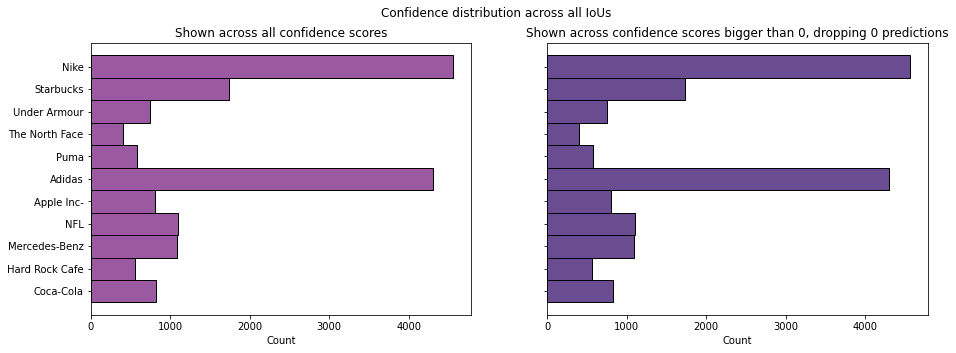

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
fig.suptitle("Confidence distribution across all IoUs")


sns.histplot(y=test_pred['true_label_name'],
            color=palette[10],
             ax=axes[0])
axes[0].set_ylabel('')
axes[0].set_xlabel('Count')
axes[0].set_title('Shown across all confidence scores')

sns.histplot(y=test_pred.loc[test_pred['list_conf']>=confidence,'true_label_name'],
            color=palette[5],
             ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('Count')
drop=len(test_pred)-len(test_pred[test_pred['list_conf']>=confidence])
axes[1].set_title(f'Shown across confidence scores bigger than {confidence}, dropping {drop} predictions')
axes[1].set_visible(True)

In [15]:
print(f"Mean IoU based on best confidence")
print('-'*30)
print(calculate_results_maxConfidence(test_pred, confidence = 0))

Mean IoU based on best confidence
------------------------------
true_label_name
Adidas            0.867175
Apple Inc-        0.851976
Coca-Cola         0.752911
Hard Rock Cafe    0.836226
Mercedes-Benz     0.866899
NFL               0.784796
Nike              0.764713
Puma              0.779045
Starbucks         0.863024
The North Face    0.844567
Under Armour      0.803334
Name: list_iou, dtype: float64


In [16]:
test_pred

,Unnamed: 0,picture,true_label,pred_label,list_iou,list_conf,true_bounding,pred_bounding,iou_range,confidence_range,true_label_name,area_predicted,area_true,aspect_ratio_true
0,0,charlotte_1019088214340003257_20150630_jpg.rf....,0,9,0.000000,0.016192,"[339, 394, 381, 439]","[557, 50, 591, 78]",IoU = 0,IoU < 0.5,Nike,952,1890,1.071429
1,1,charlotte_1019088214340003257_20150630_jpg.rf....,0,1,0.000000,0.016574,"[339, 394, 381, 439]","[624, 239, 639, 351]",IoU = 0,IoU < 0.5,Nike,1680,1890,1.071429
2,2,charlotte_1019088214340003257_20150630_jpg.rf....,0,0,0.000000,0.027949,"[339, 394, 381, 439]","[339, 396, 380, 439]",IoU = 0,IoU < 0.5,Nike,1763,1890,1.071429
3,3,charlotte_1019088214340003257_20150630_jpg.rf....,0,0,0.000000,0.075455,"[339, 394, 381, 439]","[149, 409, 186, 438]",IoU = 0,IoU < 0.5,Nike,1073,1890,1.071429
4,4,charlotte_1061715143228072770_20150828_jpg.rf....,0,8,0.000000,0.010139,"[8, 27, 225, 108]","[625, 213, 639, 286]",IoU = 0,IoU < 0.5,Nike,1022,17577,0.373272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16768,16768,phoenix_1935985515900093585_20181217_jpg.rf.5b...,9,9,0.869364,0.833240,"[539, 362, 589, 395]","[542, 363, 590, 396]",IoU > 0.5,IoU > 0.5,Coca-Cola,1584,1650,0.660000
16769,16769,phoenix_1946363108408644084_20181231_jpg.rf.5a...,9,2,0.000000,0.010330,"[239, 211, 403, 287]","[0, 350, 133, 638]",IoU = 0,IoU < 0.5,Coca-Cola,38304,12464,0.463415
16770,16770,phoenix_1946363108408644084_20181231_jpg.rf.5a...,9,1,0.000000,0.037609,"[239, 211, 403, 287]","[620, 0, 640, 18]",IoU = 0,IoU < 0.5,Coca-Cola,360,12464,0.463415
16771,16771,phoenix_1946363108408644084_20181231_jpg.rf.5a...,9,9,0.000000,0.110511,"[239, 211, 403, 287]","[346, 328, 446, 392]",IoU = 0,IoU < 0.5,Coca-Cola,6400,12464,0.463415


In [17]:
scores_conf = pd.DataFrame(calculate_results_maxConfidence(test_pred, confidence = 0)).reset_index()
scores_pred = pd.DataFrame(calculate_results_maxIoU(test_pred, confidence = 0.061)).reset_index()


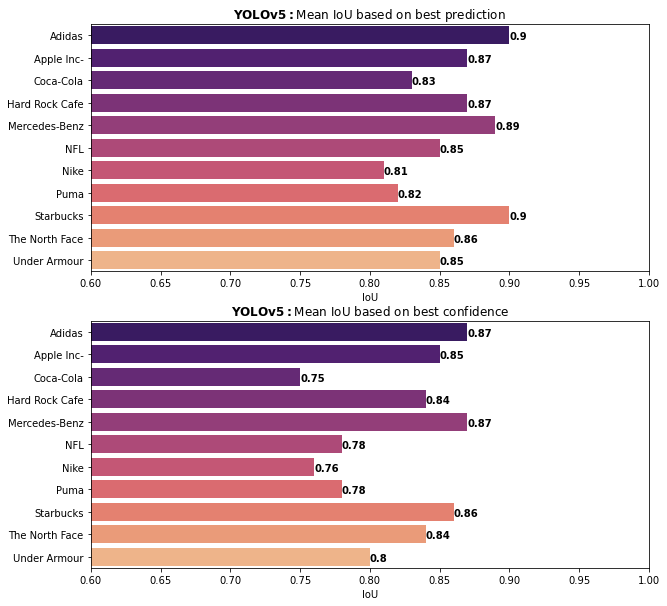

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))

sns.barplot(x = np.round(scores_pred['list_iou'],2), y = scores_pred['true_label_name'], 
            palette = palette[5:30:2], ax = axes[0])
axes[0].set_xlim(0.6, 1)
#axes[1].axvline(x=0.80, c= 'red', lw = 3, )
#axes[1].axvline(x=0.85, c= 'red', lw = 3, )
axes[0].set_title(r"$\bf{YOLOv5:}$Mean IoU based on best prediction")
for i, v in enumerate(scores_pred['list_iou']):
    axes[0].text(np.round(v,2), 0.18+i, round(v,2), color='black', fontweight='bold')
axes[0].set_xlabel('IoU')
axes[0].set_ylabel('')

sns.barplot(x = np.round(scores_conf['list_iou'],2), y = scores_conf['true_label_name'], 
            palette = palette[5:30:2], ax = axes[1])
axes[1].set_xlim(0.6, 1)
#axes[0].axvline(x=0.80, c= 'red', lw = 3)
#axes[0].axvline(x=0.85, c= 'red', lw = 3)
axes[1].set_title(r"$\bf{YOLOv5:}$Mean IoU based on best confidence")
axes[1].set_xlabel('IoU')
axes[1].set_ylabel('')
for i, v in enumerate(scores_conf['list_iou']):
    axes[1].text(np.round(v,2), 0.18+i, round(v,2), color='black', fontweight='bold')

Plot overall confidence distribution on all predicitons 

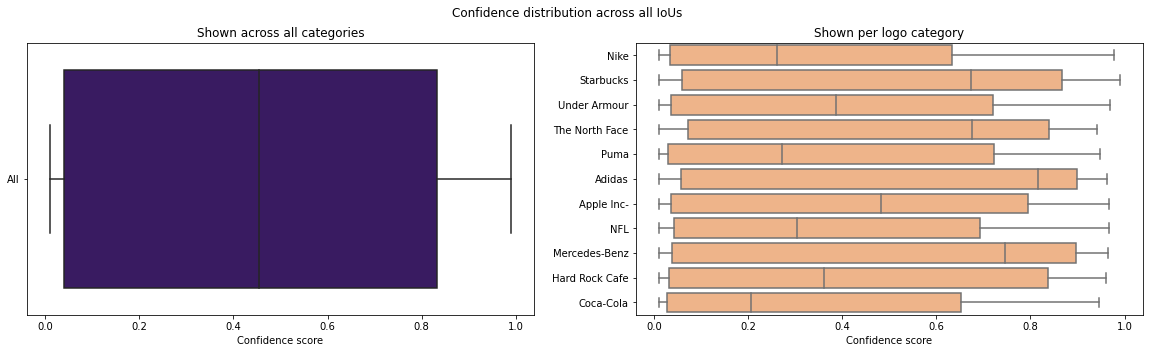

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle("Confidence distribution across all IoUs")

sns.boxplot(y=['All']*len(test_pred.loc[test_pred['list_conf']>=confidence,'true_label']),
            x=test_pred.loc[test_pred['list_conf']>=confidence,'list_conf'], color=palette[5],ax=axes[0])
axes[0].set_ylabel('')
axes[0].set_xlabel('Confidence score')
axes[0].set_title('Shown across all categories')

sns.boxplot(y='true_label_name',x='list_conf',data=test_pred[test_pred['list_conf']>=confidence], color=palette[-5],ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('Confidence score')
axes[1].set_title('Shown per logo category')
axes[1].set_visible(True)

Now lets look at confidence distribution across different levels of IoU

In [20]:
test_pred = test_pred.sort_values(by= ['iou_range'], ascending=False)

In [21]:
import matplotlib.pyplot as plt

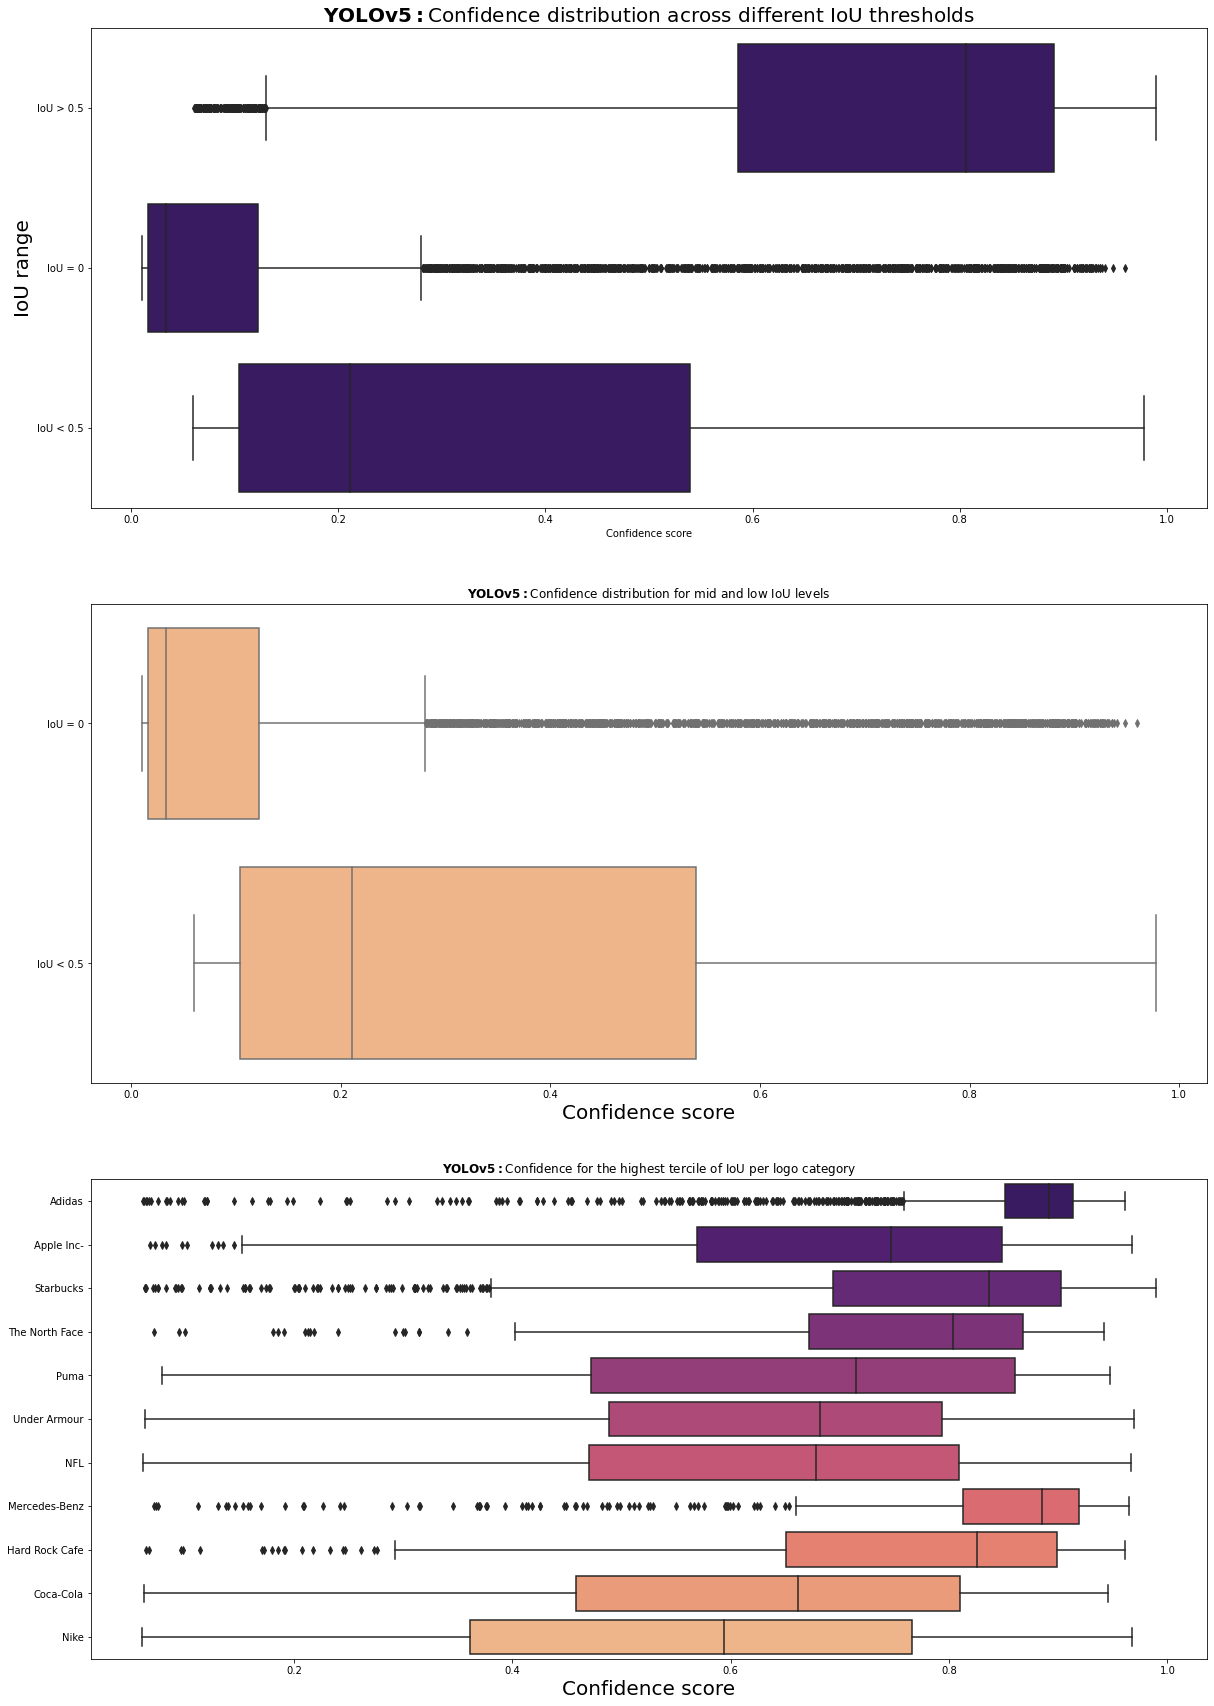

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(20,30))

sns.boxplot(y=test_pred['iou_range'],x=test_pred['list_conf'], color=palette[5],ax=axes[0])
axes[0].set_ylabel('IoU range', fontsize = 20)
axes[0].set_xlabel('Confidence score')
axes[0].set_title(r"$\bf{YOLOv5:}$Confidence distribution across different IoU thresholds", fontsize = 20)


sns.boxplot(y=test_pred.loc[test_pred['iou_range']=='IoU > 0.5','true_label_name'],x=test_pred.loc[test_pred['iou_range']=='IoU > 0.5','list_conf'], palette=palette[5:30:2],ax=axes[2])
axes[2].set_ylabel('')
axes[2].set_xlabel('Confidence score',fontsize = 20)
axes[2].set_title(r"$\bf{YOLOv5:}$Confidence for the highest tercile of IoU per logo category")

sns.boxplot(y=test_pred.loc[test_pred['iou_range'] != 'IoU > 0.5','iou_range'],x=test_pred.loc[test_pred['iou_range']!='IoU > 0.5','list_conf'], color=palette[-5],ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('Confidence score', fontsize = 20)
axes[1].set_title(r"$\bf{YOLOv5:}$Confidence distribution for mid and low IoU levels")

axes[0].set_visible(True)

Analysis on average number of predicted bounding boxes per image

In [23]:
confidence = 0.06

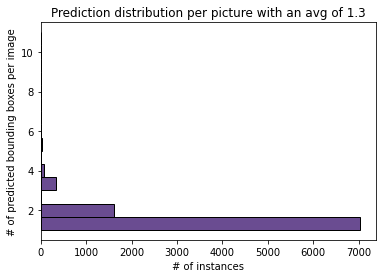

In [24]:
stats=pd.DataFrame(test_pred[test_pred['list_conf']>=confidence].groupby('picture')['pred_bounding'].count())
avg_bb_image=stats['pred_bounding'].mean()
ax=sns.histplot(y=stats['pred_bounding'],color=palette[5])
ax.set_title(f'Prediction distribution per picture with an avg of {np.round(avg_bb_image,2)}')
ax.set_ylabel('# of predicted bounding boxes per image')
ax.set_xlabel('# of instances')
ax.set_visible(True)

Bounding box area distribution for true and predicted labels


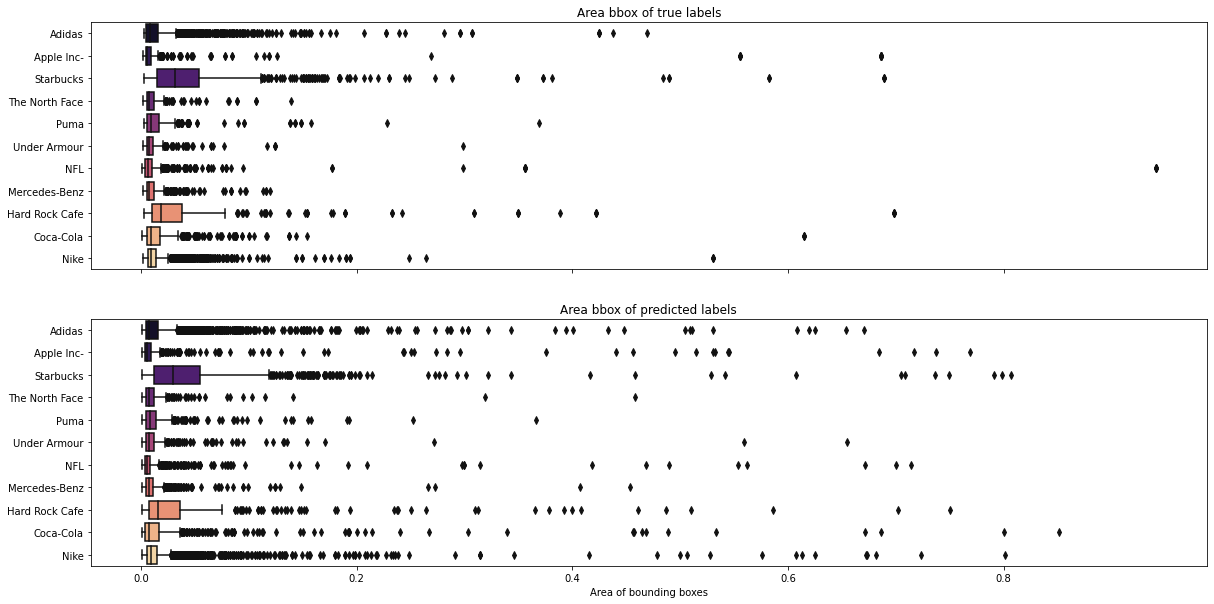

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True, sharey=True)

investigate_area_true=test_pred.loc[test_pred['list_conf']>=confidence,['area_true','true_label_name','iou_range','confidence_range']]
investigate_area_true['area_true'] = investigate_area_true['area_true'] / scale

sns.boxplot(x='area_true', y='true_label_name', 
            data=investigate_area_true, ax=ax[0], palette=p_name)
ax[0].set_title('Area bbox of true labels')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

investigate_area=test_pred.loc[test_pred['list_conf']>=confidence,['area_predicted','true_label_name','iou_range','confidence_range']]
investigate_area['area_predicted'] = investigate_area['area_predicted'] / scale

sns.boxplot(x='area_predicted', y='true_label_name', 
            data=investigate_area, ax=ax[1], palette=p_name)
ax[1].set_title('Area bbox of predicted labels')
ax[1].set_ylabel('')
ax[1].set_xlabel('Area of bounding boxes')

ax[1].set_visible(True)

Too many outliers, lets zoom in!

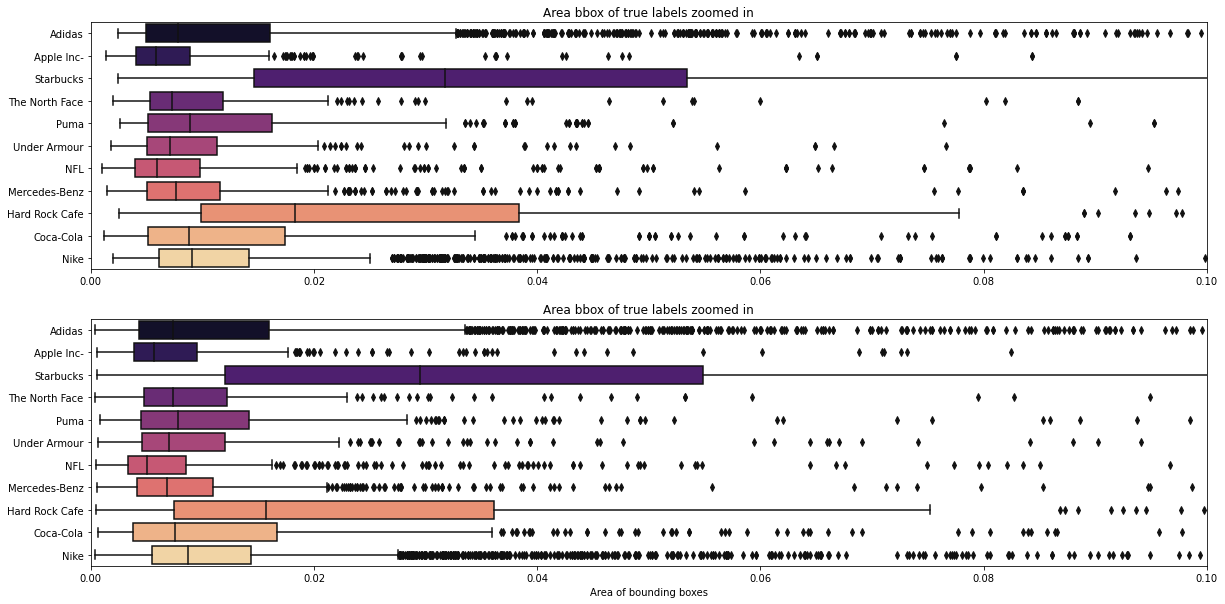

In [26]:
zoom=0.1
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharey=True)
sns.boxplot(x='area_true', y='true_label_name', 
            data=investigate_area_true, ax=ax[0], palette=p_name)
ax[0].set_title('Area bbox of true labels zoomed in')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xlim(left=0,right=zoom)


sns.boxplot(x='area_predicted', y='true_label_name', 
            data=investigate_area, ax=ax[1], palette=p_name)
ax[1].set_title('Area bbox of true labels zoomed in')
ax[1].set_ylabel('')
ax[1].set_xlabel('Area of bounding boxes')
ax[1].set_xlim(left=0, right=zoom)

ax[1].set_visible(True)

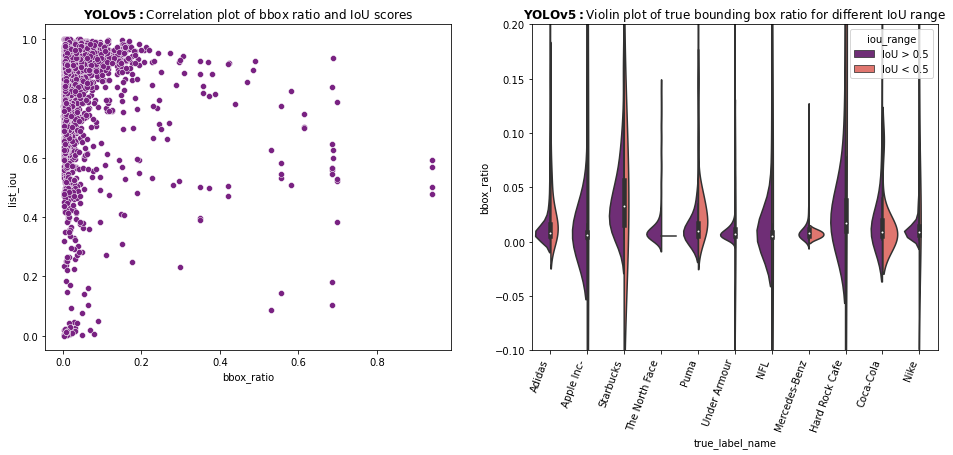

In [27]:
"""
Analysis of the bounding box ratio and aspect ratio distribution across the low and high IoU groups
"""
test_pred["bbox_ratio"] = test_pred["area_true"] / (640*640)
no_zeros_df = test_pred.loc[(test_pred["list_iou"] > 0) &(test_pred["list_conf"] > 0.06)] 
no_zeros_df

fig, axs = plt.subplots(1,2,figsize = (16,6))

ax = axs[0]
sns.scatterplot(x = no_zeros_df["bbox_ratio"],y =  no_zeros_df["list_iou"],ax = ax, color = palette[10])
ax.set_title(r"$\bf{YOLOv5:}$" + "Correlation plot of bbox ratio and IoU scores")

ax = axs[1]
sns.violinplot(x = no_zeros_df["true_label_name"],y = no_zeros_df["bbox_ratio"], hue = no_zeros_df["iou_range"], split = True,ax = ax, palette= palette[10::10])
ax.set_title(r"$\bf{YOLOv5:}$" + "Violin plot of true bounding box ratio for different IoU range")
ax.set_xticklabels(no_zeros_df["true_label_name"].unique(),rotation = 70, horizontalalignment = "right")
ax.set_ylim(-0.1,0.2)


plt.show()

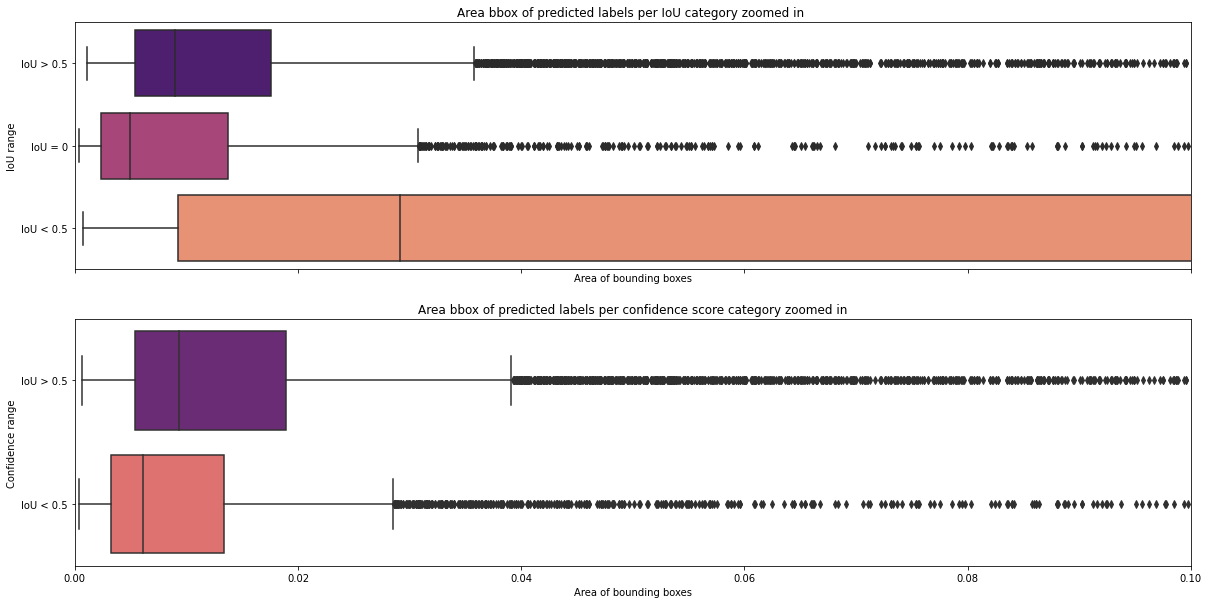

In [28]:
zoom=0.1
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)

sns.boxplot(x='area_predicted', y='iou_range', 
            data=investigate_area, ax=ax[0], palette=p_name)
ax[0].set_title('Area bbox of predicted labels per IoU category zoomed in ')
ax[0].set_ylabel('IoU range')
ax[0].set_xlabel('Area of bounding boxes')
ax[0].set_xlim(left=0,right=zoom)


sns.boxplot(x='area_predicted', y='confidence_range', 
            data=investigate_area, ax=ax[1], palette=p_name)
ax[1].set_title('Area bbox of predicted labels per confidence score category zoomed in')
ax[1].set_ylabel('Confidence range')
ax[1].set_xlabel('Area of bounding boxes')
ax[1].set_xlim(left=0, right=zoom)

ax[1].set_visible(True)

## Analysis on labels with high confidence but 0 IoU

In [29]:
pictures_investigate = test_pred.loc[(test_pred['list_conf']>=confidence) & (test_pred['list_iou']==0), :].reset_index(drop=True)
print("Number of pictures to investigate: ",len(pictures_investigate['picture'].unique()))
pictures_investigate.head()

Number of pictures to investigate:  2035


,Unnamed: 0,picture,true_label,pred_label,list_iou,list_conf,true_bounding,pred_bounding,iou_range,confidence_range,true_label_name,area_predicted,area_true,aspect_ratio_true,bbox_ratio
0,1915,houston_1681624099217448308_20171231_jpg.rf.ae...,0,0,0.0,0.257220,"[489, 194, 604, 239]","[185, 465, 311, 539]",IoU = 0,IoU < 0.5,Nike,9324,5175,0.391304,0.012634
1,13651,la_2017_1518090131801421712_20170519_jpg.rf.07...,7,9,0.0,0.144246,"[373, 88, 414, 140]","[168, 274, 216, 302]",IoU = 0,IoU < 0.5,Mercedes-Benz,1344,2132,1.268293,0.005205
2,12847,chicago_1238704924359987350_20160428_jpg.rf.8d...,8,8,0.0,0.097606,"[8, 408, 639, 639]","[208, 264, 252, 336]",IoU = 0,IoU < 0.5,NFL,3168,145761,0.366086,0.355862
3,13572,houston_1524164450855261113_20170527_jpg.rf.3c...,7,7,0.0,0.066527,"[373, 3, 463, 136]","[246, 317, 273, 346]",IoU = 0,IoU < 0.5,Mercedes-Benz,783,11970,1.477778,0.029224
4,13605,la_2017_1505331068706060766_20170501_jpg.rf.a8...,6,2,0.0,0.060845,"[43, 561, 81, 617]","[0, 0, 20, 36]",IoU = 0,IoU < 0.5,Apple Inc-,720,2128,1.473684,0.005195


Overall statistics on the labels under investigation

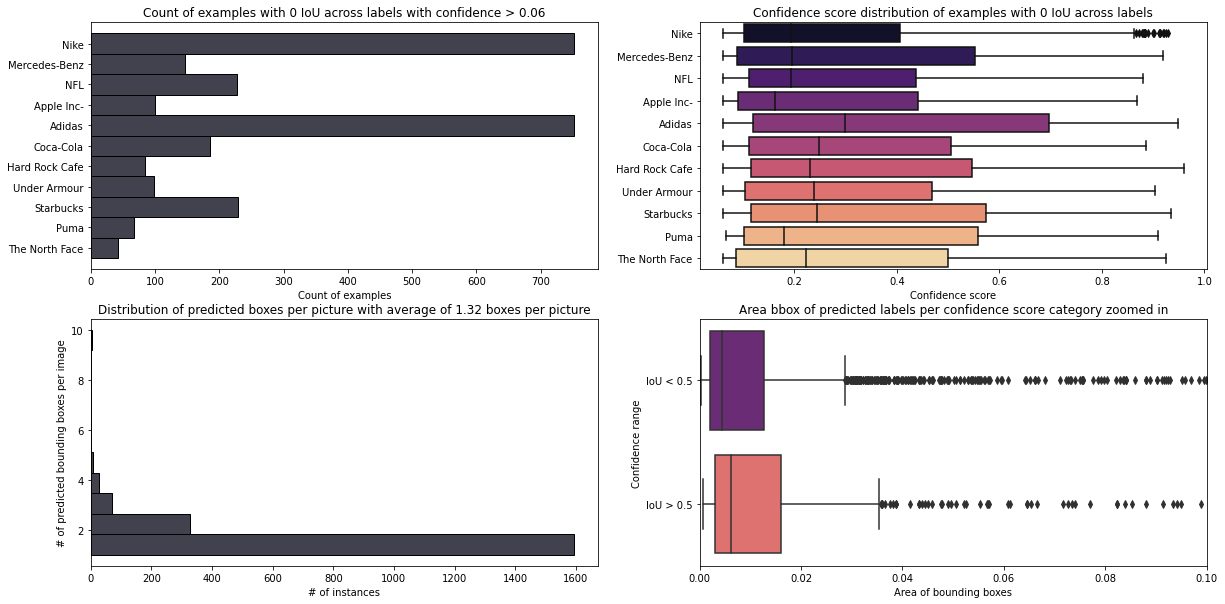

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))


sns.histplot(y=pictures_investigate['true_label_name'], color=palette[0],bins=11, ax=axes[0,0])
axes[0,0].set_title(f'Count of examples with 0 IoU across labels with confidence > {confidence}')
axes[0,0].set_xlabel('Count of examples')
axes[0,0].set_ylabel('')

sns.boxplot(y= pictures_investigate['true_label_name'], x=pictures_investigate['list_conf'], palette=p_name, ax=axes[0,1])
axes[0,1].set_title(f'Confidence score distribution of examples with 0 IoU across labels')
axes[0,1].set_xlabel('Confidence score')
axes[0,1].set_ylabel('')

stats=pd.DataFrame(pictures_investigate[pictures_investigate['list_conf']>=confidence].groupby('picture')['pred_bounding'].count())
avg_bb_image=stats['pred_bounding'].mean()
sns.histplot(y=stats['pred_bounding'], color=palette[0],bins=11, ax=axes[1,0])
axes[1,0].set_title(f'Distribution of predicted boxes per picture with average of {np.round(avg_bb_image,2)} boxes per picture')
axes[1,0].set_xlabel('# of instances')
axes[1,0].set_ylabel('# of predicted bounding boxes per image')

investigate_area=pictures_investigate.loc[pictures_investigate['list_conf']>=confidence,['area_predicted','true_label_name','iou_range','confidence_range']]
investigate_area['area_predicted'] = investigate_area['area_predicted'] / scale

sns.boxplot(x='area_predicted', y='confidence_range', 
            data=investigate_area, 
            ax=axes[1,1], palette=p_name)
axes[1,1].set_title('Area bbox of predicted labels per confidence score category zoomed in')
axes[1,1].set_ylabel('Confidence range')
axes[1,1].set_xlabel('Area of bounding boxes')
axes[1,1].set_xlim(left=0, right=0.1)

axes[1,1].set_visible(True)

Investigating whether there might be differences between the labels under investigation and the true labels associated to the respective pictures

/home/3054408/.conda/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(0.0, 2.5)

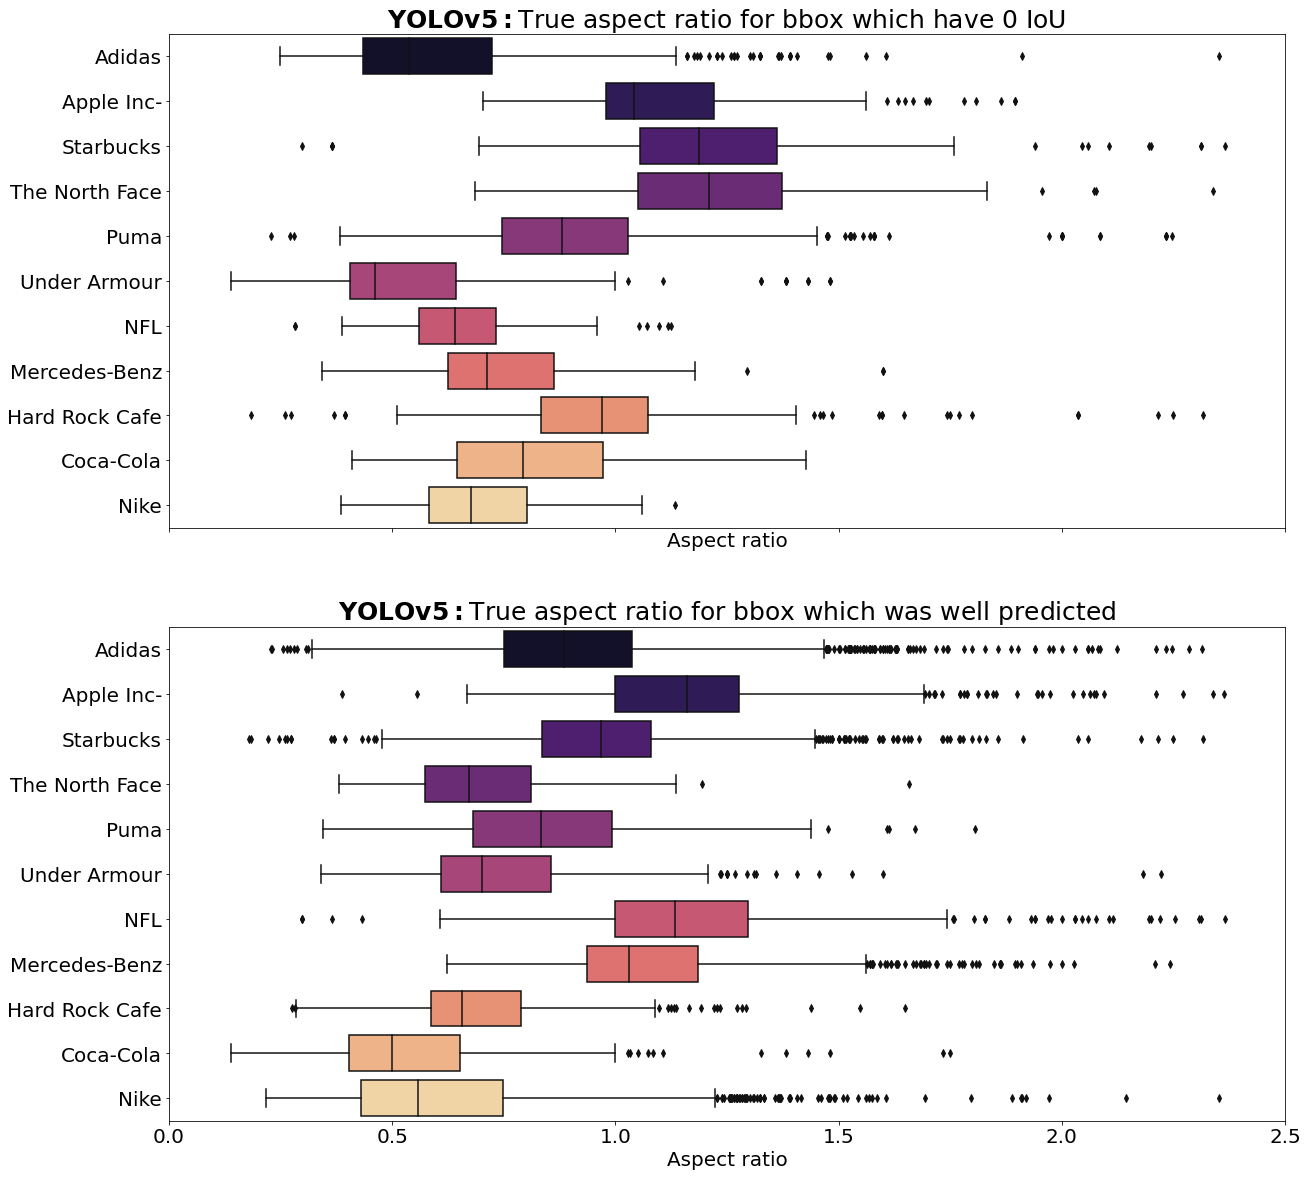

In [31]:
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

fig, ax = plt.subplots(2, 1, figsize=(20,20), sharey=True, sharex=True)
sns.boxplot(x=pictures_investigate['aspect_ratio_true'], y=pictures_investigate['true_label_name'], ax=ax[0],palette=p_name)
ax[0].set_title(r"$\bf{YOLOv5:}$True aspect ratio for bbox which have 0 IoU", fontsize = 25)
ax[0].set_ylabel("")
ax[0].set_xlabel("Aspect ratio", fontsize = 20)
ax[0].set_xlim(0, 2.5)


result = test_pred.loc[test_pred.groupby(['picture'])['list_conf'].transform(max) == test_pred['list_conf'],:]
result.loc[result['list_conf'] < confidence, 'list_iou'] = 0
sns.boxplot(x=result['aspect_ratio_true'], y=result['true_label_name'], ax=ax[1], palette=p_name)
ax[1].set_title(r"$\bf{YOLOv5:}$True aspect ratio for bbox which was well predicted", fontsize = 25)
ax[1].set_ylabel("")
ax[1].set_xlabel("Aspect ratio", fontsize = 20)
ax[1].set_visible(True)
ax[1].set_xlim(0, 2.5)

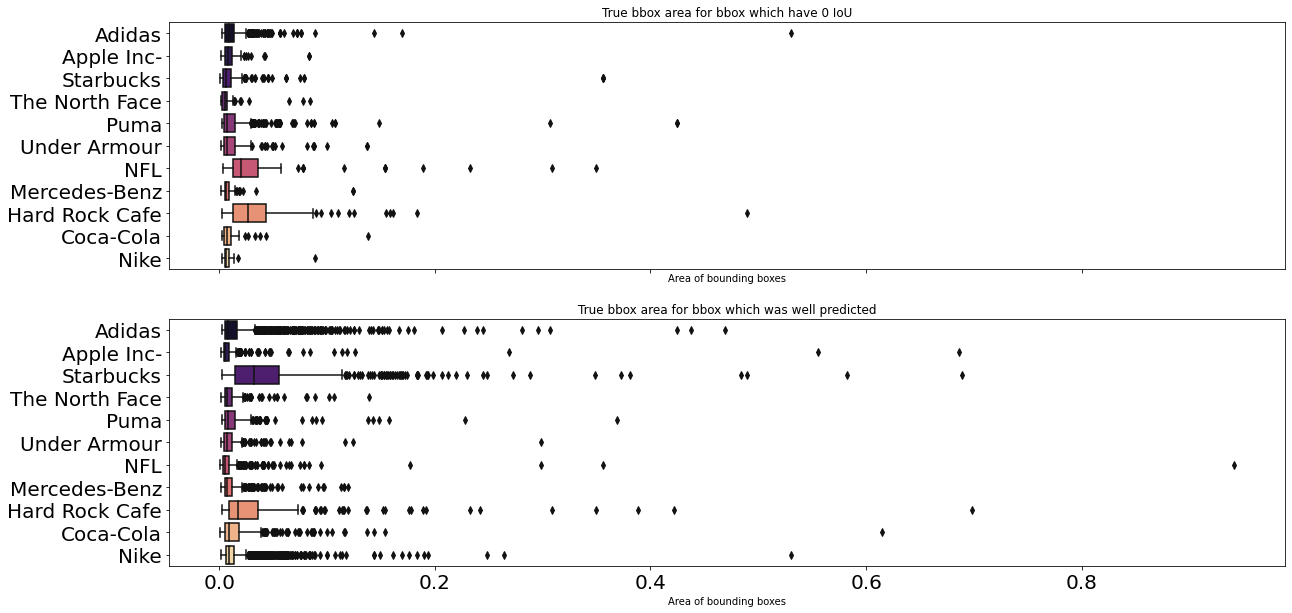

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharey=True, sharex=True)
sns.boxplot(x=pictures_investigate['area_true']/scale, y=pictures_investigate['true_label_name'], ax=ax[0], palette=p_name)
ax[0].set_title('True bbox area for bbox which have 0 IoU')
ax[0].set_ylabel("")
ax[0].set_xlabel("Area of bounding boxes")

sns.boxplot(x=result['area_true']/scale, y=result['true_label_name'], ax=ax[1], palette=p_name)
ax[1].set_title('True bbox area for bbox which was well predicted')
ax[1].set_ylabel("")
ax[1].set_xlabel("Area of bounding boxes")
ax[1].set_visible(True)

In [33]:
def show_bbox(test_pic_path, pictures_investigate, test_pred, n_show=3, start=-1):

  assert n_show % 3 == 0

  rows= int(n_show / 3)
  fig, axes = plt.subplots(rows,3,figsize = (30,15), squeeze=True)
  axes = axes.reshape(-1)
  pic_show = pictures_investigate.loc[:,'picture'].unique()

  if start == -1:
    start=np.random.randint(0,len(pic_show)-n_show)
  else:
    start = start


  for i, ax in  enumerate(axes):
    pic= pic_show[start+i]
    image = Image.open(test_pic_path + pic)
    resized_image = image.resize((img_size,img_size))

    true_bb= test_pred.loc[test_pred['picture']==pic, 'true_bounding'].values[0]

    show_box(true_bb, ax , linewidth = 2,edgecolor = 'blue',facecolor = 'none')
    
    for box, iou, conf in np.array(test_pred.loc[test_pred['picture']==pic, ['pred_bounding','list_iou','list_conf']]):
      if conf > confidence:
        show_box(box, ax , linewidth = 2,edgecolor = 'red',facecolor = 'none')
    ax.imshow(resized_image)

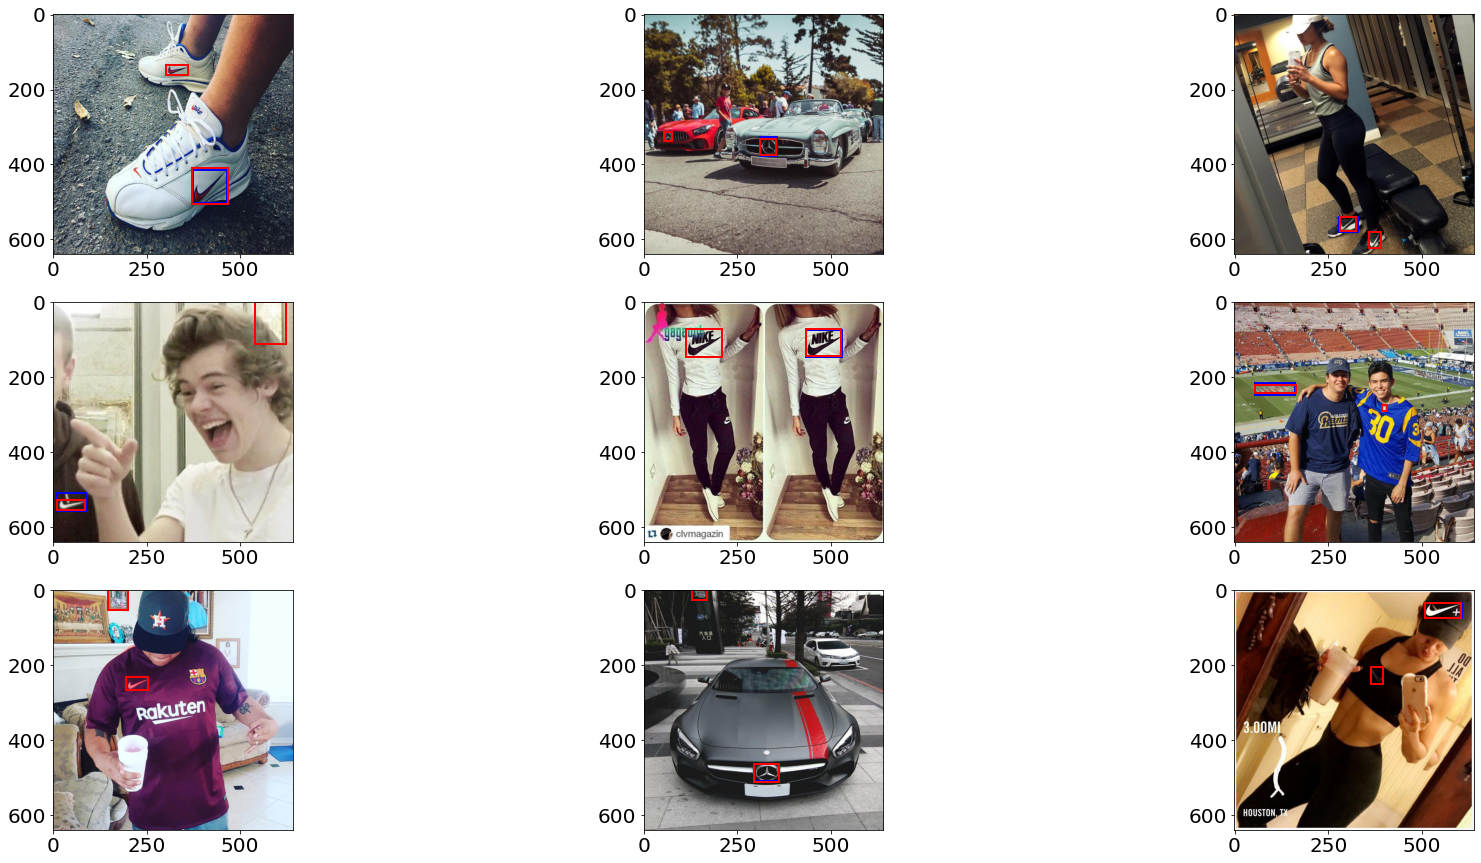

In [45]:
#
show_bbox(test_pic_path, pictures_investigate, test_pred, n_show=9, start=69)

In [40]:
bad_pred = 2+1 + 2 + 3 + 1 + 3 + 1
all_pred = 9+12 + 9 + 9 + 11 +11 +9

In [41]:
bad_pred/all_pred

0.18571428571428572

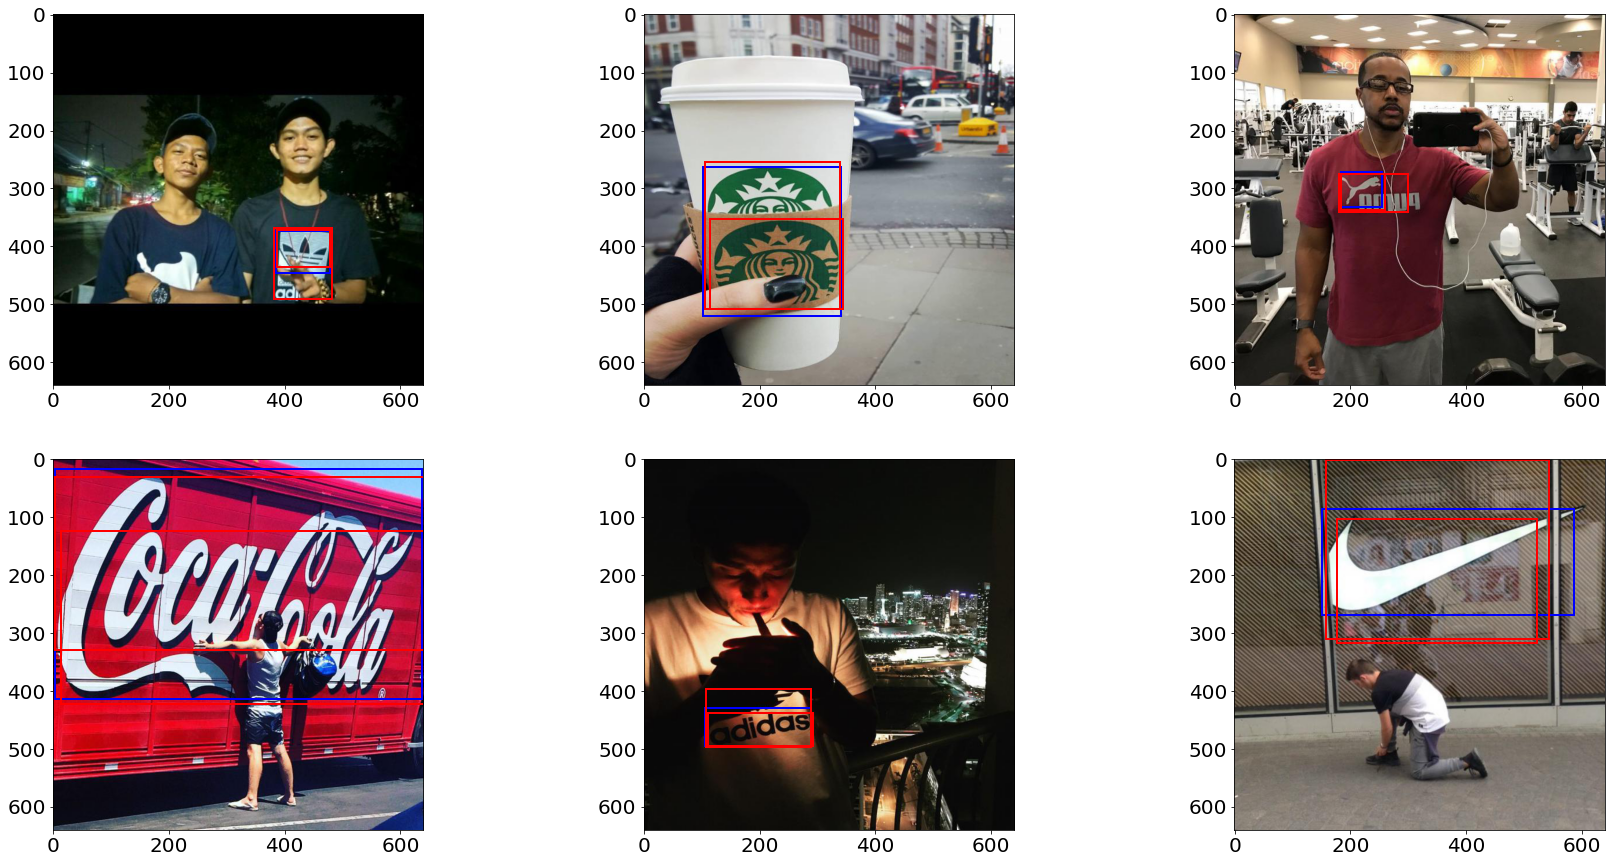

In [46]:
"""
Print the bounding boxes that are better than the best fitting bounding box based on IoU

"""

#gets the best prediction based on IoU
best = test_pred.loc[test_pred.groupby(by = "picture")["list_iou"].idxmax().values,["picture", "list_conf"]].rename({"picture" : "path", "list_conf": "best_conf"},axis = 1)

#Merge back to all predictions to check if the best confidence better than the confidence of that prediction
higher_conf = pd.merge(test_pred,best,left_on = "picture", right_on = "path", how = "left")
higher_conf_with_best = higher_conf.loc[higher_conf["best_conf"] <= higher_conf["list_conf"]]
higher_conf = higher_conf.loc[higher_conf["best_conf"] < higher_conf["list_conf"]]

#Plot n images
n = 6 #multiple of 3
show_bbox(test_pic_path, higher_conf, higher_conf_with_best, n_show=n, start=0)

In [47]:
#good logos (do not count the true logos)
#total logos (do not count the true logos)

good_logos = 5 + 5 + 5 + 4 + 10 + 6 + 5 + 5 + 3 + 4 + 3 + 4 + 4 + 3 + 10 + 4 + 6 + 2 + 5 + 3 + 5 + 7 + 4 + 5 + 6 + 4 + 7 + 4 + 0 + 4 + 4 + 4 + 8 + 6 + 2 + 5 + 5 + 2 + 3 + 5 + 7 + 3 + 5 + 9 + 6 + 7 + 8 + 6 + 8 + 6 + 7 + 11 + 7 + 7 + 12 + 10 + 11 + 18 + 12 + 17 + 9  + 12 + 14 + 10 + 8 + 9 + 12 + 9 + 8 + 9  + 10 + 11 + 6 + 8 + 7 + 8 + 10 + 8 + 9 + 7 + 5  
total_boxes = 6 + 5 + 7 + 4 + 14 + 6 + 5 + 6 + 4 + 6 + 6 + 4 + 8 + 4 + 11 + 5 + 6 + 3 + 6 + 5 + 5 + 7 + 6 + 5 + 9 + 4 + 7 + 4 + 1 + 4 + 5 + 4 + 8 + 6 + 2 + 6 + 6 + 3 + 3 + 6 + 7 + 5 + 5 + 9 + 9 + 9 + 8 + 8 + 11 + 9+ 7 + 11 + 7 + 9 + 12 + 11 + 11 + 18 + 13 + 17 + 10 + 14 + 14 + 10 + 9 + 9 + 14 + 9 + 9 + 10 + 10 + 11 + 8 + 9 + 6 + 9 + 11 + 8 + 12 + 8 + 5
good_logos/total_boxes

0.8860353130016051

In [48]:
total_boxes

623